# Liquid Argon tpc Reconstruction Done in pythON : LARDON
![logog](figures/lardon_logo_np02.png)

Laura Zambelli (LAPP, CNRS/USMB, FRANCE)

*On behalf of the DUNE experiment*

This is a presentation-friendly version of LARDON, the full code is available at <https://github.com/lzambell/lardon>.

*Contents* : 
  * [Liquid Argon TPCs](#Liquid-Argon-TPCs)
  * [Events and Reconstruction Flow](#Events-and-Reconstruction-Flow)
  * [Noise removal](#Noise-Removal)
  * [Hit Finder](#Hit-Finder)
  * [2D Track](#2D-Track)
  * [3D Track](#3D-Track)
  * [Reconstruction Results](#Reconstruction-Results)

In [31]:
'''Import Needed Libraries '''
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne 
import bottleneck as bn
import tables as tab

''' some python code to read hdf5 data, store it as a class and plot it '''
import data as data
import draw as draw

%matplotlib notebook 


# Liquid Argon TPCs
Liquid Argon Time Projection Chamber (LArTPC) is the technology foreseen to study neutrino oscillation in the [DUNE experiment](https://www.dunescience.org/).

A LArTPC is a chamber in which a uniform field - the *drift field* - is applied. When a charged particle crosses the chamber, e<sup>-</sup>/Ar<sup>+</sup> pairs are produced by ionization along the particle path. The electrons are attracted towards the anode thanks to the drift field at a constant speed. These electrons are then captured at the anode (with strips, wires, ...) along 2 or 3 projections (time-space).

Given the scale of the foreseen detectors of DUNE (4 modules of about $60\times12\times12$ m<sup>3</sup> each), smaller protoypes have be been built at CERN to test different technology. One of them, called *dual phase*, has the specificity to amplify the electron cloud before its collection in a small gaseous layer:

<img src="figures/lartpc.png" alt="lartpc" width="300"/>

This prototype, *protoDUNE-DP*, took cosmic rays data in 2019-2020. Its volume is $6\times6\times6$ m<sup>3</sup>, but only half of the collection plane was instrumented:
<img src="figures/inside_protodune_dp.png" alt="lartpc" width="350"/>

Here are the conventions used in LARDON : 
<img src="figures/protodunedp_convention_angles.png" alt="lartpc" width="400"/>

# Events and Reconstruction Flow

## Reconstruction problem
The problem of the reconstruction is to retrieve what happened in 3D from 2D projections. With the protoDUNE-DP design, we have 2 orthogonal views. 
While the problem might be not very complicated at first, the following animation highlights some of the problems encountered during the reconstruction: noise, random hits, ambiguities, ...

The animation is a *very* simplified example!

![gif](figures/recogif.gif "recogif")

The reconstruction approach in LARDON is very classic:
1. Filter the noise
2. Identify hits
3. Build 2D tracks as line-like
4. Match the 2D tracks from different projections to build 3D events

Other methods are explored by the LArTPC community: machine-learning, particle flow, ... 

## A Typical Event 
Here is one event of ProtoDUNE-DP data taken in October 2019 with cosmic rays:

* The time axis has 10'000 bins which corresponds to 4ms: one bin is 400ns.

* Each channel axis has 960 bins which corresponds to 3m: one bin is 3.125mm.

* The tracks appears bended due to a technical issue in the detector (a short circuit) that will not be futher discussed in this presentation. Technically speaking, the data is reconstructed *as if* the field was at a constant value of 166 V/cm.


![raw](figures/ed_crp_0_1_talk_raw_run_1294_evt_1.png)

# Noise Removal

There are 3 kind of noise identified in our data :
   1. **White Noise** : small random ADC fluctuations
   2. **Coherent Noise** : noise seen at the same time by several consecutive channels. This is consequence of some part of the dectector acting like antenna
   3. **Microphonic Noise** : slow ADC fluctuation in time and space. The most convincing hypothesis so far for its origin is that one element of the detector vibrates changing the capacitance

In [2]:
'''  Basic Region Of Interest (ROI) finder based on ADC threshold '''
def ROI_ADC(i, thresh):
    data.mask = ne.evaluate( "where((data > thresh), 0, 1)", global_dict={'data':data.data[i]}).astype(bool)

def get_RMS(i):
    return np.std(data.data[i], axis=-1, where=data.mask)

''' More advanced ROI finder based on threshold over the pedestal RMS '''
def ROI_RMS(i, thresh):
    ped_rms =  get_RMS(i)[:,None]
    data.mask = ne.evaluate( "where((data > thresh*ped_rms), 0, 1)", global_dict={'data':data.data[i]}).astype(bool)

In [3]:
''' read a sub-set of the shown event to play with the noise filtering algorithms'''
def read_data():
    with tab.open_file("data/1294_1_a_sub_raw_data.h5", "r") as f:
        d = f.root.rawdata.read()[0][0]
        p = f.root.pedestal.read()[0][0]
        data.data[data.level['raw']] = d - p[:,None]

read_data()

The data is stored in data.data as an np.array with a dimension of (4, nchannels=320, ntimebins=10000) where :
* `data.data[0]` contains *raw* event
* `data.data[1]` contains event after *FFT filter*
* `data.data[2]` contains event after *Coherent filter*
* `data.data[3]` contains event after *Microphonic filter* (filtered event)

A mask is also in data.mask as a boolean np.array with dimension of (nchannels=320, ntimebins=10000). It tells wether one point is considered being noise (`True`) or signal (`False`):

In [ ]:
''' Compute the mask / Region of Interest '''
ROI_ADC(0, 6) #first a basic ROI finder
ROI_RMS(0, 2.5) #RMS-based ROI finder

## White noise removal

The method to filter the data from the white noise is to apply a low-pass FFT filter. There is a smooth gaussian cut after the frequency threshold to avoid ringing artifacts.

The following code let you play with the low pass threshold (in MHz).

<IPython.core.display.Javascript object>


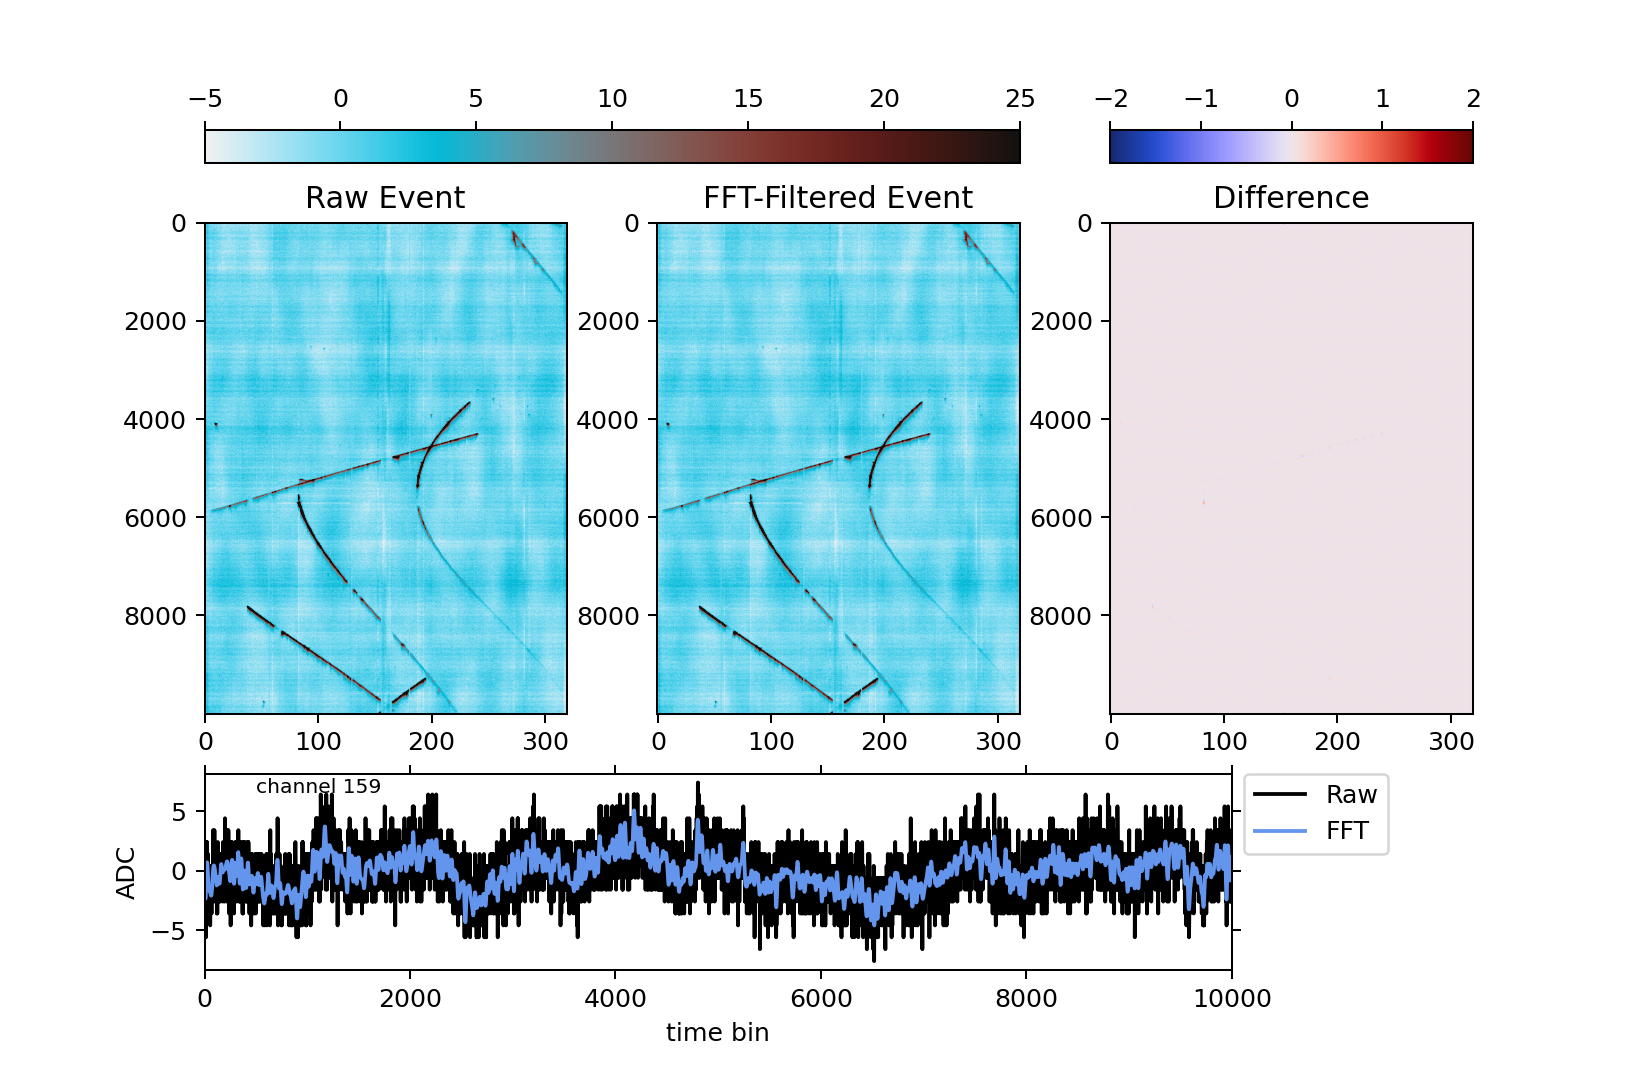

interactive(children=(FloatSlider(value=0.15, description='lowpass', max=0.3, step=0.01), IntSlider(value=159,…

In [24]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def fft_filter(lowpass):    
    n    = int(10000/2) +1
    rate = 1./0.4 #in MHz
    freq = np.linspace(0, rate/2., n)
    
    """define gaussian low pass filter"""
    gauss_cut = np.where(freq < lowpass, 1., gaussian(freq, lowpass, 0.02))
    
    fdata = np.fft.rfft(data.data[0])
    
    """Apply filter"""
    fdata *= gauss_cut[None, :]

    """go back to time"""
    data.data[1] = np.fft.irfft(fdata)
   

fig = plt.figure(figsize=(9,6))
fft_filter(0.15)
axs = draw.draw_noise_first(fig, 158, 1)

@widgets.interact_manual
def fft(lowpass=(0, 0.3, 0.01), channel=(0,319,1)):    
    fft_filter(lowpass)
    draw.draw_noise_update(fig, axs, channel, 1);
   

In [5]:
plt.close()

'''Apply default FFT-cut'''
fft_filter(0.08)

''' recompute the mask from the FFT-filtered event '''
ROI_RMS(1, 2.5)

## Coherent Noise removal

The signal is carried from the inside of the detector to the outside on blades hosted in a 1m long chimneys. Each blade host 2 pairs of 32 cables, and one chimney reads a group of 320 channels of one CRP. The cables, the blades and the chimneys can act like an antenna picking up surrounding noise and seen by the concerned set of channels.

<img src="figures/coherent_noise_origin.png" alt="lartpc" width="350"/>


To remove the coherent noise, the np array hosting the data is sub-divided (reshaped) in groups of channels (32, 64 or 320). In this new dimension, the average noise is computed for each bin time and then subtracted to the whole data points.

The following code let you subtract the different coherent noise pattern.

<IPython.core.display.Javascript object>


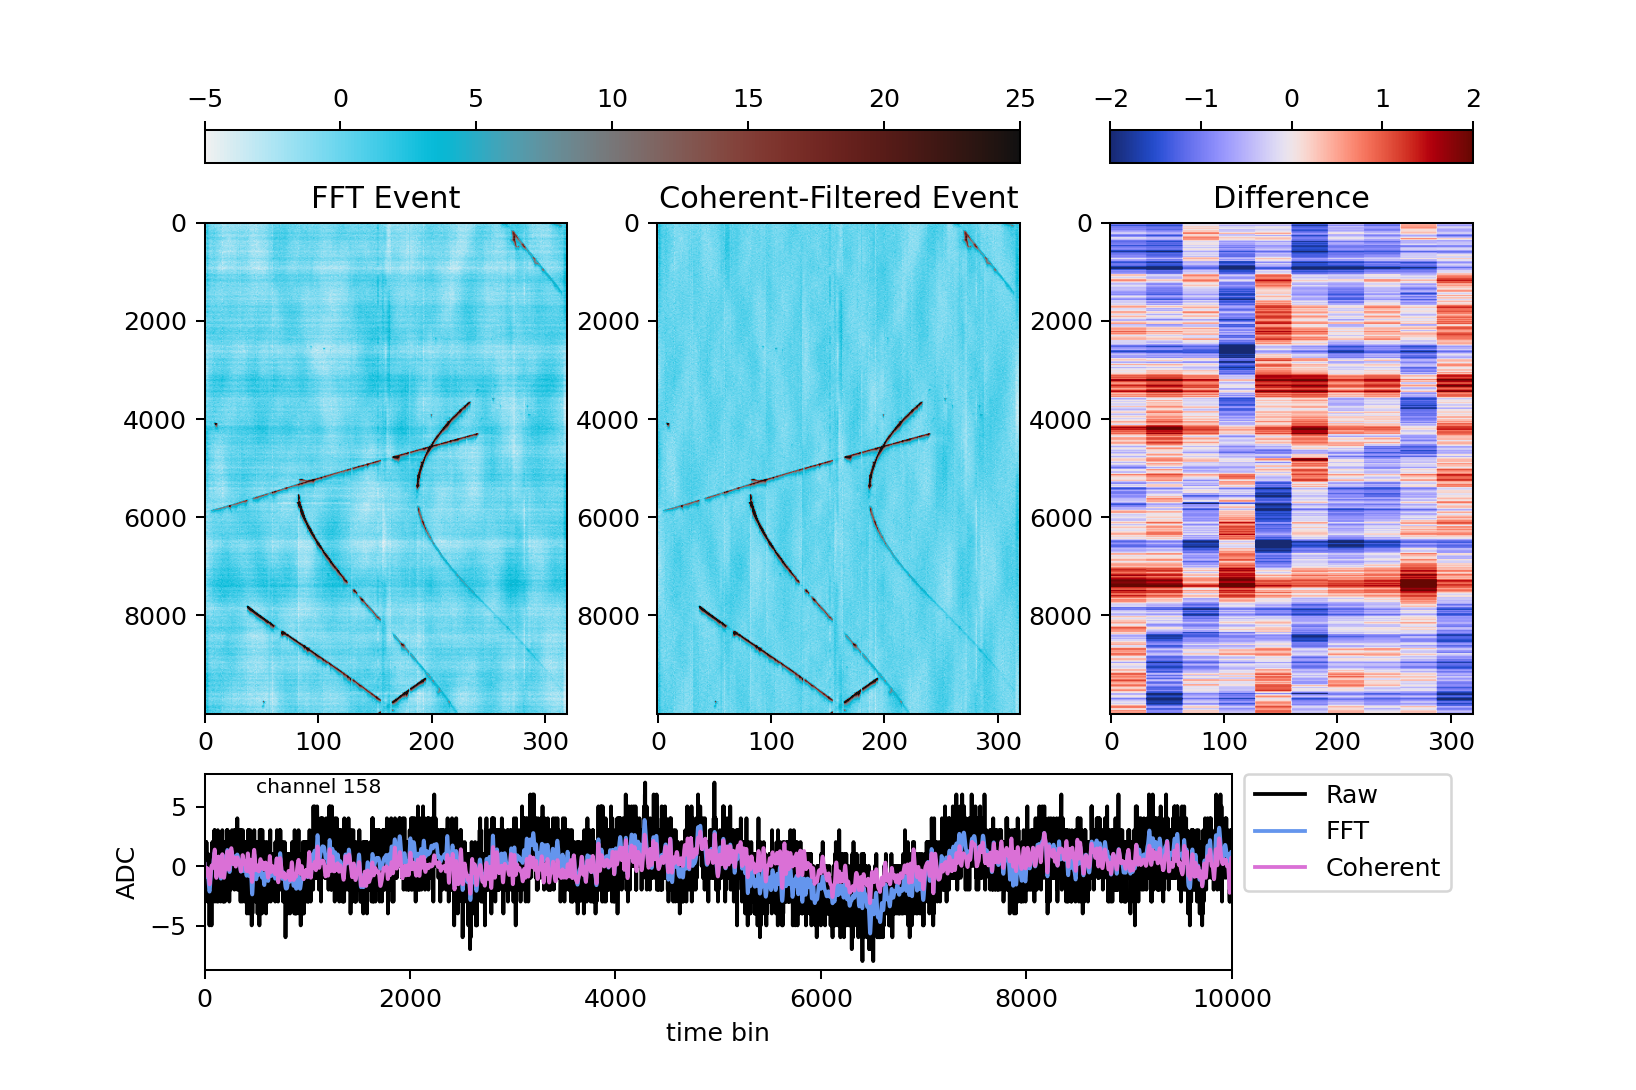

interactive(children=(Dropdown(description='group', options=('32', '64', '320'), value='32'), IntSlider(value=…

In [26]:
def coherent_filter(level_in, group):
    npts = 10000
    nslices = int(320 / group)
    data_filt = np.reshape(data.data[level_in].copy(), (nslices, group, npts))
    data_mask = np.reshape(data.mask, (nslices, group, npts))
    
   
    """sum data if mask is true"""
    with np.errstate(divide='ignore', invalid='ignore'):
        """sum the data along the N channels (subscript l) if mask is true,
        divide by nb of trues"""
        mean = np.einsum('klm,klm->km', data_filt, data_mask)/data_mask.sum(axis=1)

        """require at least 3 points to take into account the mean"""
        mean[data_mask.sum(axis=1) < 3] = 0.
 
    """Apply the correction to all data points"""
    data_filt -= mean[:,None,:]
  
    
    """ restore original data shape """
    data_filt = np.reshape(data_filt, (320, npts))
        
    data.data[2] = data_filt
    
    

fig=plt.figure(figsize=(9,6))
coherent_filter(1, 32)

axs = draw.draw_noise_first(fig, 158, 2)

@widgets.interact_manual
def coherent(group=['32','64','320'], channel=(3,317,5)):
    group = int(group)
    
    coherent_filter(1, group)
  
    draw.draw_noise_update(fig, axs, channel, 2);


In [7]:
plt.close()

''' Apply default reconstruction'''
coherent_filter(1, 320)
coherent_filter(2, 64)

''' recompute the mask from the coherent-filter event '''
ROI_RMS(2, 2.5)

## Microphonic noise removal

The microphonic noise origin is not entirely resolved. Our best hypothesis is that when the LEM (the amplification device) are under tension, they tend to vibrate varying the distance LEM->Anode. This would imply a modification of the capacitance and would create a microphonic noise.

<img src="figures/microphonic_noise_origin.png" alt="lartpc" width="350"/>

The pattern of this noise is a slow oscillation of the pedestal in time and space. It seems that we see a superposition of several waves with different periods: a fit of the pedestal with a sinusoide is complicated. The periods are anyway very small: a removal of such frequencies with the FFT is complicated without affecting the signal. 

The filter used to remove the microphonic noise is to compute the median of the noise on a sliding window for each channel and then remove it. 

The following code let you test different window size (in number of time bin).

<IPython.core.display.Javascript object>


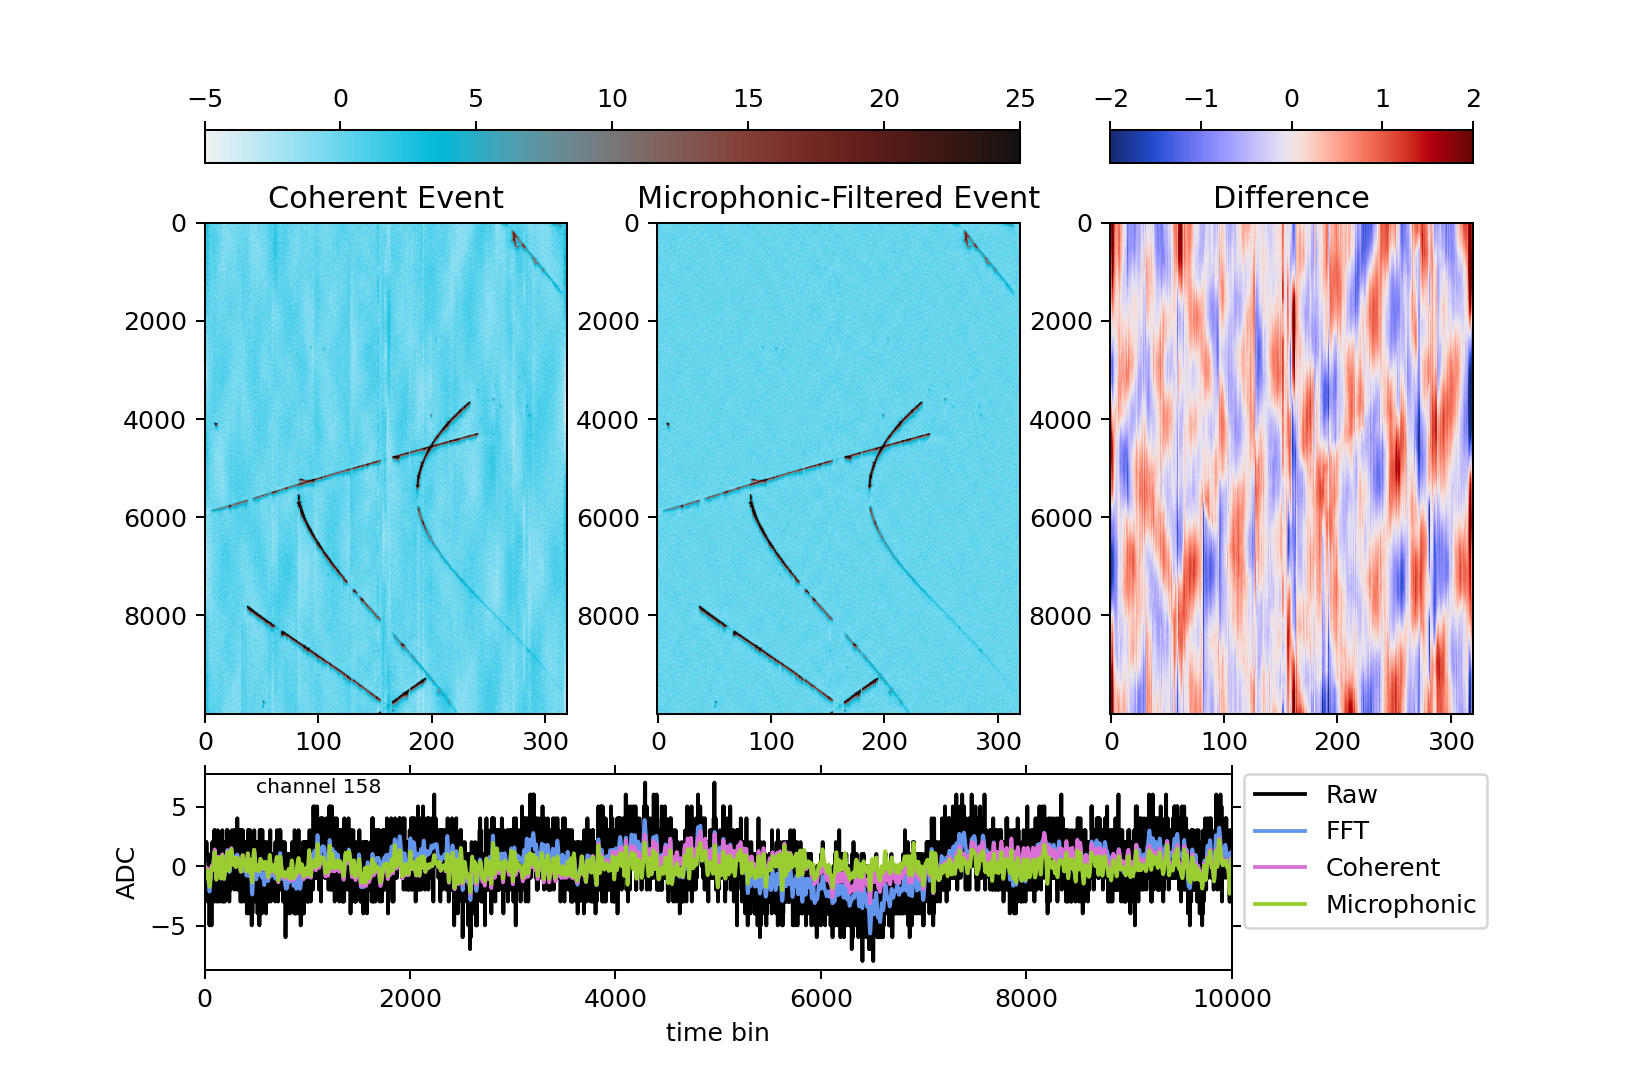

interactive(children=(IntSlider(value=1000, description='window', max=2000, min=100, step=100), IntSlider(valu…

In [27]:
def centered_median_filter(array, size):
    """ pads the array such that the output is the centered sliding median"""
    rsize = size - size // 2 - 1
    array = np.pad(array, pad_width=((0, 0) , (0, rsize)),
                   mode='constant', constant_values=np.nan)
    return bn.move_median(array, size, min_count=1, axis=-1)[:, rsize:]

def microphonic_filter(level_in, window):
    """ mask the data with nan where potential signal is (ROI)"""
    med = centered_median_filter(np.where(data.mask==True, data.data[level_in], np.nan), window)

    """ in median computation, if everything is masked (all nan) nan is returned so changed these cases to 0 """
    med = np.nan_to_num(med, nan=0.)

    """ apply correction to data points """
    data.data[3] = data.data[level_in] - med


fig=plt.figure(figsize=(9,6))
microphonic_filter(2, 1000)

axs = draw.draw_noise_first(fig, 158, 3)


@widgets.interact_manual
def microphonic(window=(100, 2000, 100), channel=(3,317,5)):
    microphonic_filter(2, window)
    draw.draw_noise_update(fig, axs, channel, 3);
    

In [9]:
plt.close()
''' Apply default reconstruction '''
microphonic_filter(2, 800)

''' recompute the mask from the microphonic-filtered event '''
ROI_RMS(3, 2.5)

## Filtering Results

The effect of the 3 filters can be seen with how the pedestal RMS has decreased

<IPython.core.display.Javascript object>


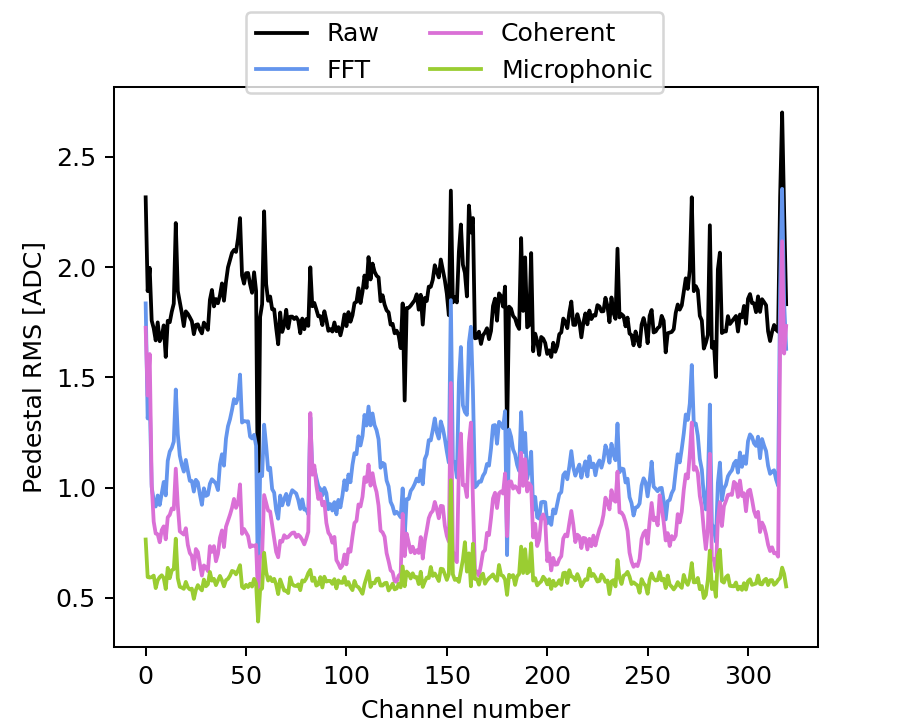

In [10]:
''' show how the pedestal RMS changed '''

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
color = ['k', 'cornflowerblue', 'orchid','yellowgreen']

for i,name in enumerate(['Raw', 'FFT', 'Coherent', 'Microphonic']):
    ped_rms = get_RMS(i)
    ax.plot(ped_rms, label=name, c=color[i])
fig.legend(ncol=2, loc='upper center')
ax.set_xlabel('Channel number')
ax.set_ylabel('Pedestal RMS [ADC]')
plt.show()

The full event filtered is : 
![raw](figures/ed_crp_0_1_talk_filt_run_1294_evt_1.png)

# Hit Finder

Now that the event has been filtered from the noise, we want to extract the signal. The mask array defines each point as signal (`True`) or noise (`False`).

Let's look at what the mask defines as signal on the sub-event we have worked on.

<IPython.core.display.Javascript object>


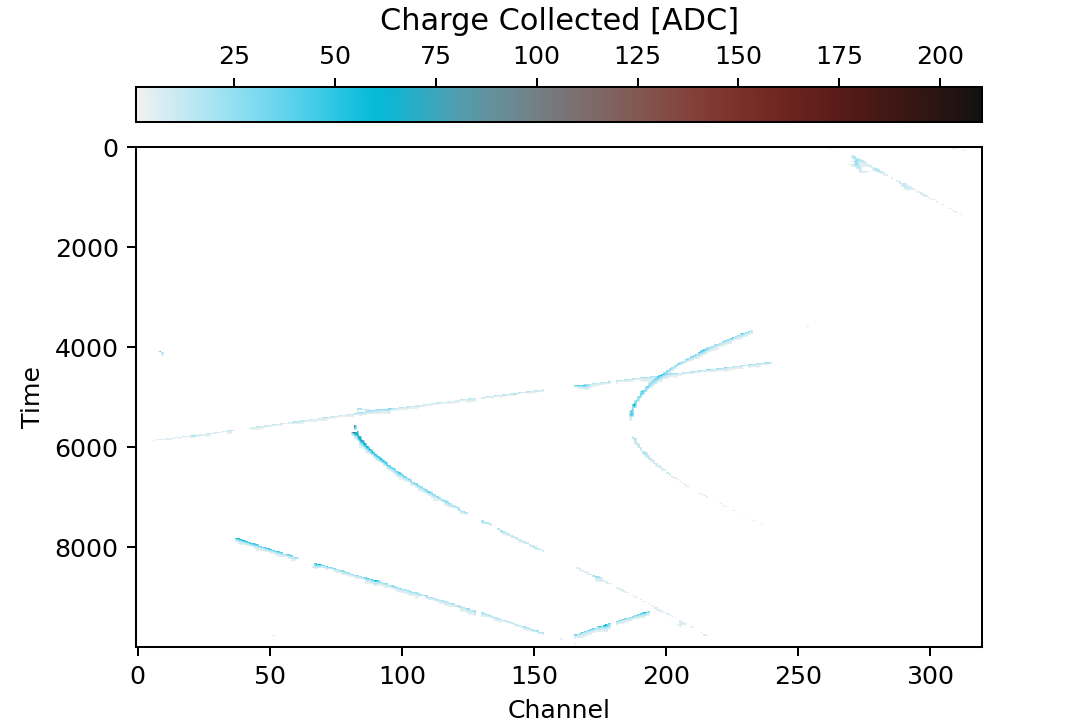

In [28]:
plt.close()

''' Now invert the mask of our sub-event and look at what is considered signal '''
signal = ~data.mask

''' take the filtered event and keep only signal '''
event = data.data[3]
event = np.where(signal, event, np.nan)



''' for a nicer plotting '''
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import colorcet as cc

''' My prefered colorblind-friendly cmap '''
my_cmap =  cc.cm.linear_tritanopic_krjcw_5_95_c24_r

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

im = ax.imshow(event.T, aspect = 'auto', cmap= my_cmap)
ax_div = make_axes_locatable(ax)
cax = ax_div.append_axes("top", size="7%", pad="5%")

cb = fig.colorbar(im, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

cax.set_title('Charge Collected [ADC]')
ax.set_ylabel('Time')
ax.set_xlabel('Channel');

To find hits, we first have to find long enough consecutive sequences of `True` in the mask array. 

On these sequences, we will apply a hit finder algorithm that recognize a signal hit from a random noisy array by looking at the shape of data: peak height, duration of the hit, existence of multiple peaks, ...

<img src="figures/hit_finder.png" alt="lartpc" width="700"/>

A simplified version of this algorithm is given to play with it. 
At this stage of the reconstruction, channel and time bin are changed to position in cm, charge collected in ADC is converted to fC. 

In [12]:
''' A class to contain hits found'''
class hits:
    def __init__(self, view, channel, x, z_start, z_stop, z_max, adc_max, charge):        
        self.view = view
        self.channel = channel

        self.adc_max = adc_max
        self.charge = charge
        
        self.X = x 
        
        self.Z_start = z_start 
        self.Z_stop  = z_stop
        self.Z       = z_max
                

In [13]:
''' Converts channel and time to cm, ADC to fC '''
def time_to_position(t):
    v = 0.0809 #e- drift velocity in cm/mus
    t *= 0.4 #bin to mus
    z = 300. - t*v
    return z

def channel_to_position(ch):
    return ch*0.3125

def ADC_to_fC(q):
    return q/89.1


''' 
A very very simplified hit finder :
- does not really look at the shape of the hit
- cannot distinguish one hit from multiple successive hits 
'''

def find_hits(adc, channel, start, thr, dt):
    t_max = np.argmax(adc)
    q_max = adc[t_max]
    
    
    above_thr = np.where(adc > thr)[0]
    if(len(above_thr) < 3):
        return []
    
    t_start = above_thr[0] 
    t_stop  = above_thr[-1]
    
    if(t_stop-t_start >= dt):
        charge = np.sum(adc[t_start:t_stop+1])
        
        h = hits(0, channel, channel_to_position(channel), 
                 time_to_position(t_start+start), 
                 time_to_position(t_stop+start), 
                 time_to_position(t_max+start), 
                 q_max, 
                 ADC_to_fC(charge))
        return [h]
    else:
        return []
    
                

In [14]:
def hit_finder(dt_min, n_sig): 
    
    ped_rms = get_RMS(3)
    
    """ invert the mask to know where the signal is """
    ROI = np.array(~data.mask, dtype=bool)

    """ add one 0 (False) and the start and end of each waveform """
    falses = np.zeros((320,1),dtype=int)
    ROIs = np.r_['-1',falses,np.asarray(ROI,dtype=int),falses]
    """ compute the  a[i+1] - a[i] difference """
    d = np.diff(ROIs)

    """ a change from false to true in difference is 1 """
    start = np.where(d==1)
    """ a change from true to false in difference is -1 """
    end   = np.where(d==-1)
    """ look at long enough sequences of trues """
    gpe = (end[1]-start[1])>=dt_min

    ''' we now know where are long enough sequences of consecutive Trues (i.e. signal) '''
    ''' we will search wether this sequence contains a hit or not (this is a simplified code here) '''
    
    for g in range(len(gpe)):
        
        channel = start[0][g]
        tdc_start = start[1][g]
        tdc_stop = end[1][g]
        
        adc = data.data[3, channel, tdc_start:tdc_stop+1]
        thr = n_sig * ped_rms[channel]
        hh = find_hits(adc, channel, tdc_start, dt_min, thr)
        for h in hh:
            data.hits_list.append(h)

In [15]:
data.hits_list = []

'''
dt_min defines how long (in number of time bin) a hit should be
n_sig defines the threshold above the pedestal to consider a point as a hit (threshold = n_sig*pedestal_RMS)
'''
hit_finder(dt_min=15, n_sig=3.) 

print('-->', len(data.hits_list), ' hits found')

--> 467  hits found


Let's look at the hits found. The boxes show the hits boundaries in time and space. 

<IPython.core.display.Javascript object>


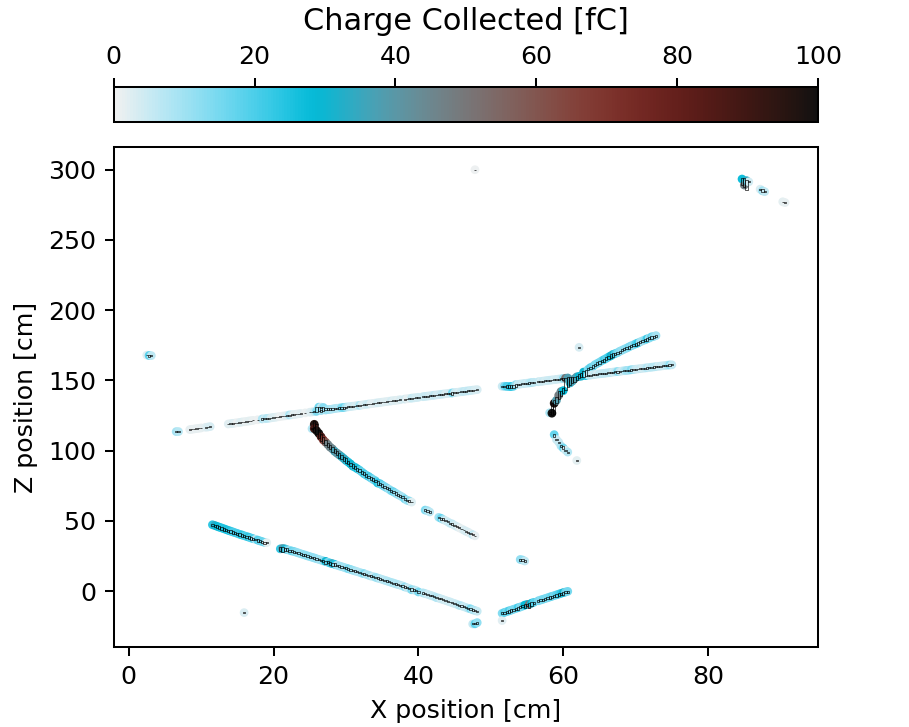

In [29]:
plt.close()

import matplotlib.patches as patches

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

box = []
pitch = 0.3125
hits_xz = []
hits_q  = []
for h in data.hits_list:
    box.append(patches.Rectangle((h.X-pitch/2.,h.Z_start),pitch,h.Z_stop-h.Z_start,linewidth=0.25,edgecolor='k',facecolor='none'))
    hits_xz.append((h.X, h.Z))
    hits_q.append(h.charge)
im = ax.scatter(*zip(*hits_xz), c=hits_q, cmap=my_cmap, s=6, vmin=0, vmax=100)

for b in box:
    ax.add_patch(b)
ax_div = make_axes_locatable(ax)
cax = ax_div.append_axes("top", size="7%", pad="5%")

cb = fig.colorbar(im, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

cax.set_title('Charge Collected [fC]')
ax.set_ylabel('Z position [cm]')
ax.set_xlabel('X position [cm]');

As expected, this simplified code cannot find hits that are too close in time. 

For the rest of the presentation, we will now use the hits found by the full reconstruction on the whole event.

In [30]:
''' import found hits from a hdf5 file '''
def read_found_hits():
    with tab.open_file("data/1294_1_a_whole_reco_results.h5", "r") as f:
        d = f.root.event_0.hits.read()
        
        for ih in d:
            data.evt_hits_list.append(hits(ih['view'], ih['channel'], ih['x'], ih['z_start'], ih['z_stop'], ih['z'], ih['adc_max'], ih['charge']))

data.evt_hits_list = []            
read_found_hits()
print('--> ', len(data.evt_hits_list), ' hits found in the event')            

3.6.1
-->  6032  hits found in the event


<IPython.core.display.Javascript object>


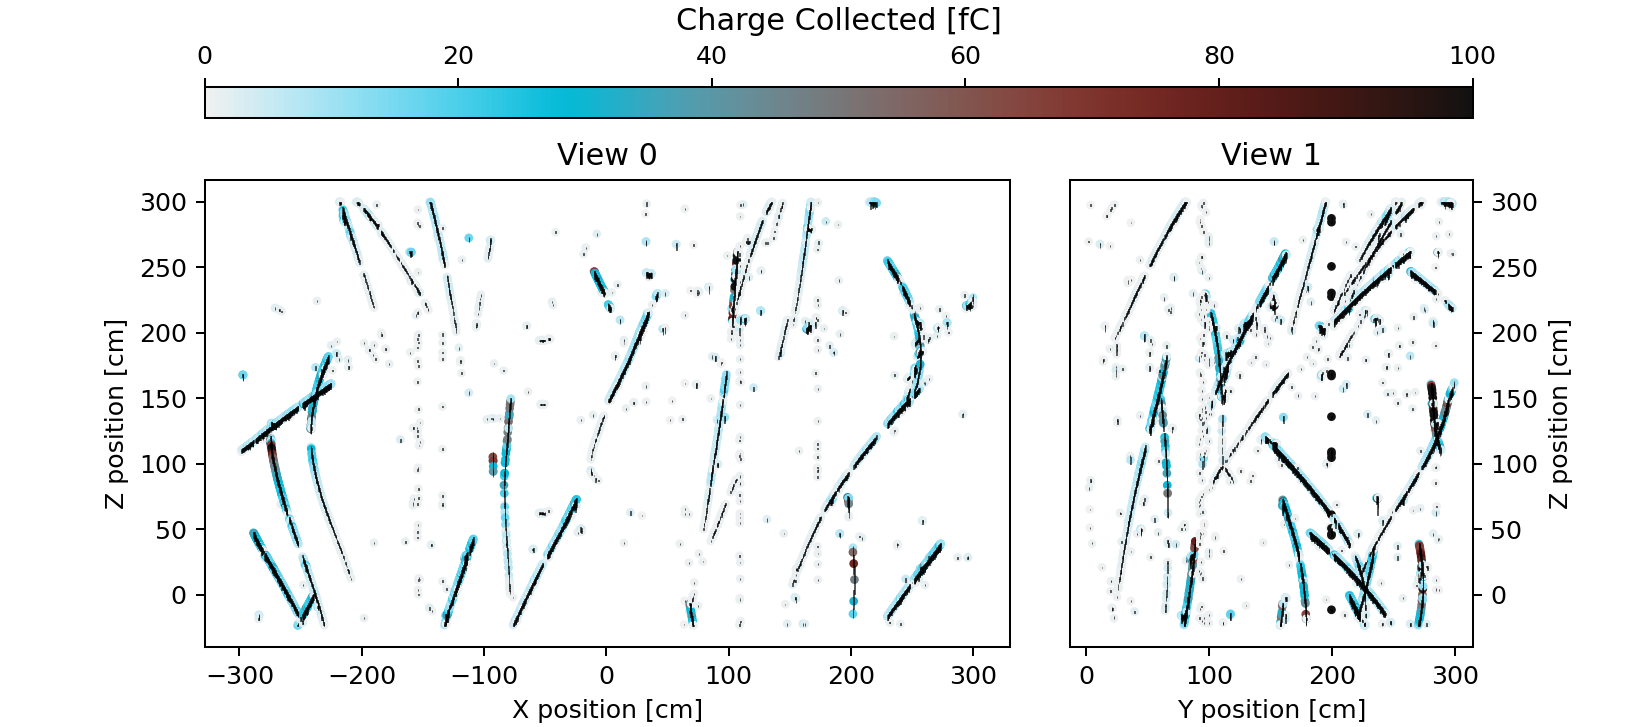

In [18]:
plt.close()
#import importlib
#importlib.reload(draw)

fig = plt.figure(figsize=(9,4))
draw.draw_hits(fig);

# 2D Track

From the collection of hits found, we will now build 2D tracks. The algorithm used is a Kalman-like and works as follow :

1. Index all hits in a R-tree (rectangular tree). From a chosen hit (defined as a box with its X/Y position and Z duration) we know which are the closest ones.
2. Choose one hit not yet attached to a 2D track or not yet tested to be attached to a 2D track (i.e. a hit still in the R-tree indexes)
3. Initialize a track with its nearest hits: find the best combination of hits that make a 2D line $z = a*x+b$
4. Given the initial slope ($a$) and intercept ($b$) and last hit attached to the line, we can test if the nearest hits can belong to the track or not. A $\chi^2$ is computed for all tested hits. If the $\chi^2$ is below a cut, the hit is accepted, and the slope and intercept are updated according to this new point. Due to multiple scattering (and short cut) the track are not expected to be straight lines, hence the parameters are allowed to vary to account for a slight bending.
5. Continue until no more hits can be attached to the track. If the track meets certain criteria (nb of hits mostly) the 2D track is kept. All hits tested and attached are removed from the R-tree index pool. The algorithm starts again at step 2 until the R-tree is empty. 

<img src="figures/2D_track_example.png" alt="2D_pfilter" width="400"/>

 **NB : I'll update that schematic drawing later**


Given that some parts of the detectors are un-instrumented (from screws, protective surface to avoid discharges, problematic channels, ...) tracks can be reconstructed as several broken pieces. A stitching algorithm is ran on all found 2D tracks, mainly based on slopes compatibilities and distances.


Once 2D tracks are found and stitched together, a deltay-ray finder algorithm is used. A MST-graph (Minimum Spanning Tree) is built on the track. Delta-rays are identified from graph vertices : where a hit is connected to more than 2 other hits.

<img src="figures/delta_ray_example_mst.png" alt="2D_MST" width="400"/>


These steps are not provided here but can be found on the lardon github (). The result of the 2D track search is given for the event considered so far.

In [19]:
''' class to contain found 2D tracks'''
class trk2D:
    def __init__(self, view, path, charge):
        self.view = view
        self.path = path #as a list of (x,z) tuples
        self.charge = charge

-->  78 2D tracks found


<IPython.core.display.Javascript object>


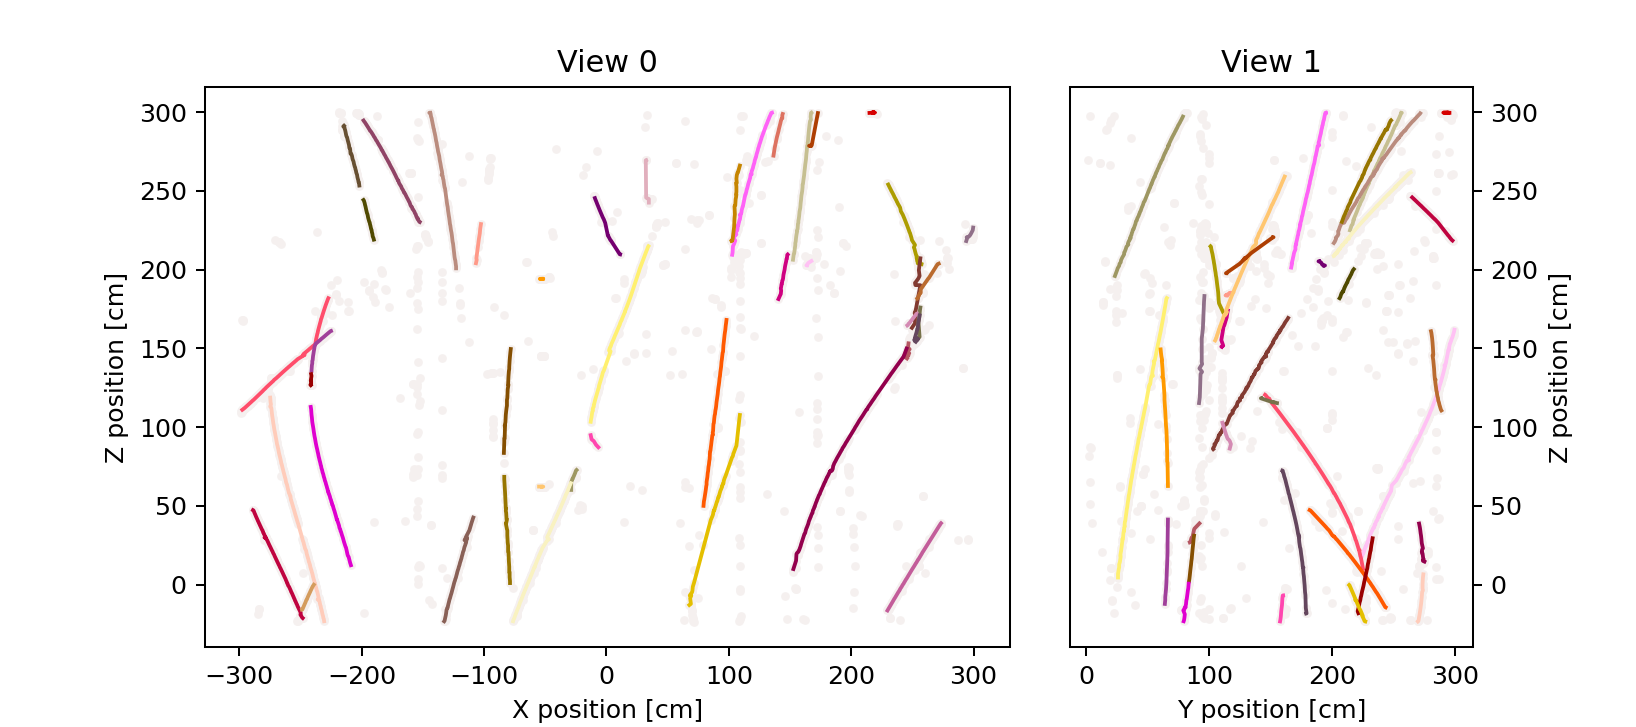

In [20]:
#import importlib
#importlib.reload(draw)

''' import 2D tracks found from hdf5 file '''
def read_found_2Dtracks():
    with tab.open_file("data/1294_1_a_whole_reco_results.h5", "r") as f:
        
        for a in f.list_nodes("/event_0/tracks2D_v0", classname='Array'):
            path = [(h[0], h[1]) for h in a]
            charge = [h[2] for h in a]            
            data.evt_trk2D_list.append(trk2D(0, path, charge))

        for a in f.list_nodes("/event_0/tracks2D_v1", classname='Array'):
            path = [(h[0], h[1]) for h in a]
            charge = [h[2] for h in a]            
            data.evt_trk2D_list.append(trk2D(1, path, charge))

            
data.evt_trk2D_list = []            
read_found_2Dtracks()
print('--> ', len(data.evt_trk2D_list), '2D tracks found')

fig = plt.figure(figsize=(9,4))
draw.draw_2Dtracks(fig)

Dots are the found hits. Each line represent a found 2D track, the color only helps to distinguish one track from an other.

# 3D Track

3D tracks are built from the association of two 2D tracks together, one in each view. 

The two tracks must overlap in time, with either the starting or ending time be the same (within a small tolerance). By construction in the dual phase design, the charge is evenly collected on each view. This specificity is used to disentangle ambiguities when searching for the best 2D track match : the charge balance between the two views are computed within the overlaping times.

For each 2D track in each view, its best match counterpart (if any) is found. When both tracks have the same match, a 3D track is built : the missing coordinate in one view is computed from the other track interpolated path. 

For each hits, we can then compute the 3D unit length, needed to corrected the charge hit and get the local $\frac{dQ}{ds}$ which is mandatory for calorimetric studies. 

In [21]:
''' class to contain found 3D tracks '''
class trk3D:
    def __init__(self, view, path, charge):
        self.view = view
        self.path = path #as a list of (x,y,z) tuples
        self.charge = charge

-->  30 3D tracks found


<IPython.core.display.Javascript object>


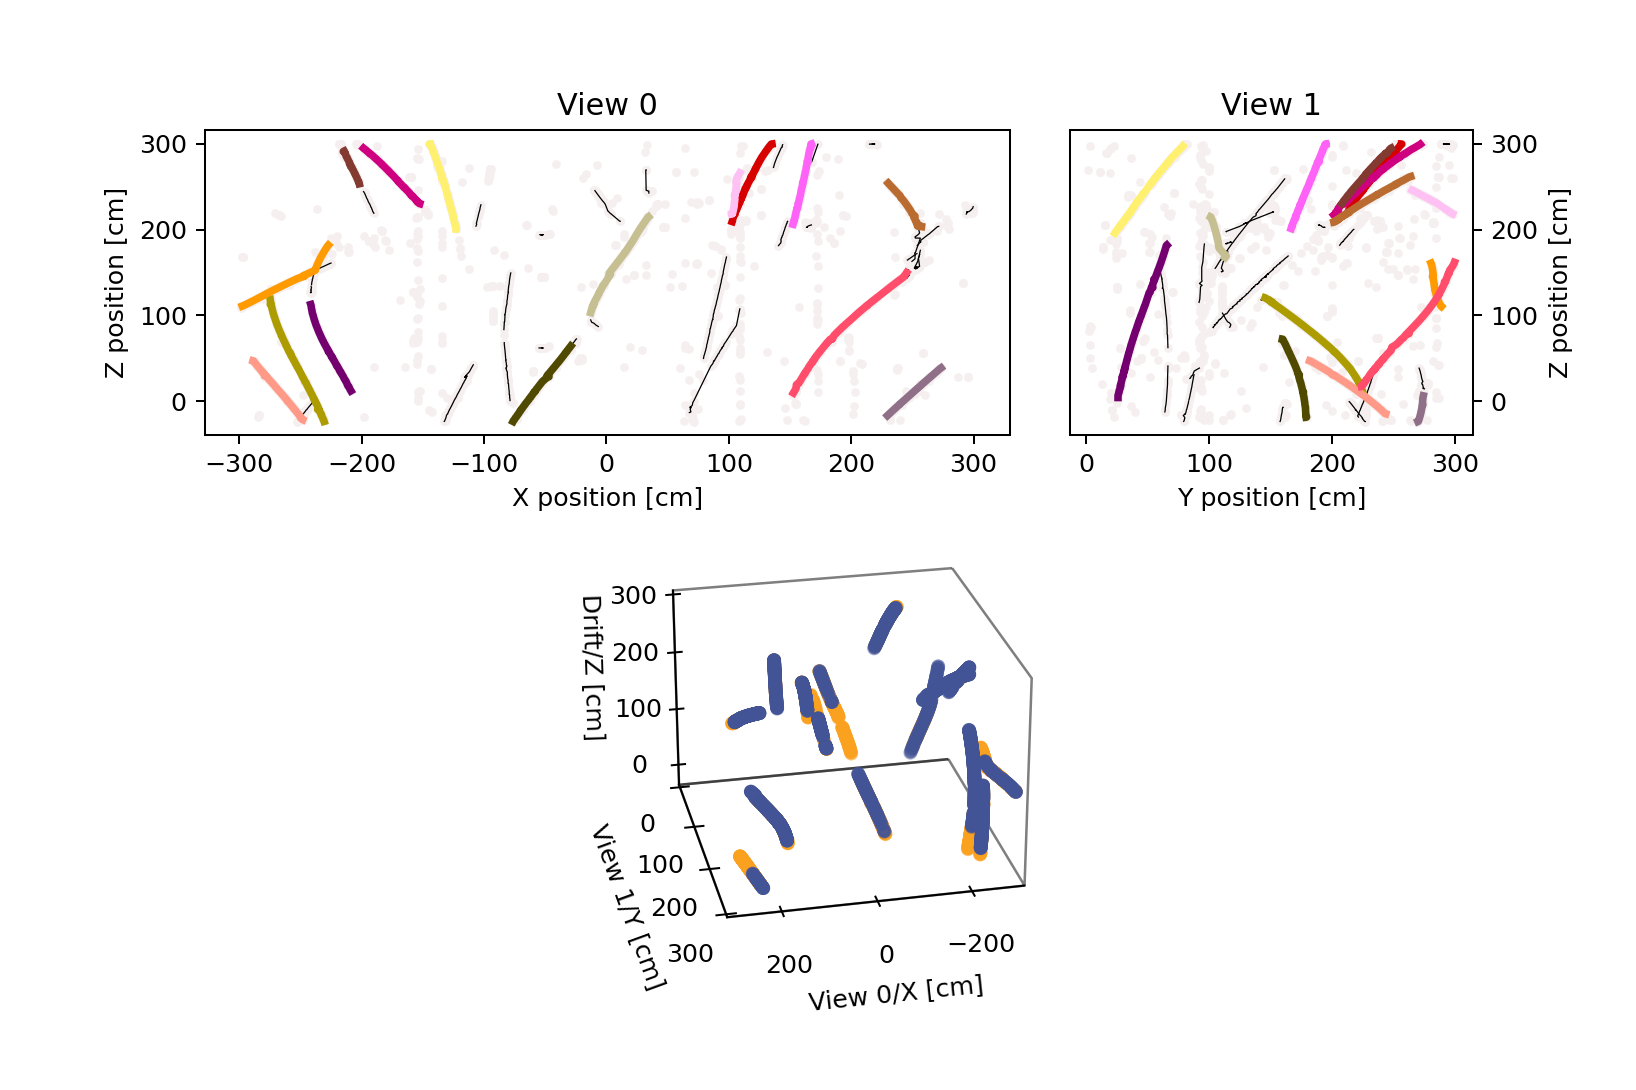

In [23]:
#import importlib
#importlib.reload(draw)

def read_found_3Dtracks():
    with tab.open_file("data/1294_1_a_whole_reco_results.h5", "r") as f:
        
        for a in f.list_nodes("/event_0/tracks3D_v0", classname='Array'):
            path = [(h[0], h[1], h[2]) for h in a]
            charge = [h[3] for h in a]            
            data.evt_trk3D_list.append(trk3D(0, path, charge))

        for a in f.list_nodes("/event_0/tracks3D_v1", classname='Array'):
            path = [(h[0], h[1], h[2]) for h in a]
            charge = [h[3] for h in a]            
            data.evt_trk3D_list.append(trk3D(1, path, charge))

            
data.evt_trk3D_list = []            
read_found_3Dtracks()
print('--> ', len(data.evt_trk3D_list), '3D tracks found')

fig = plt.figure(figsize=(9,6))
draw.draw_3Dtracks(fig);

On the top plot, the dots are the found hits, the thin dark lines are the unmatched 2D tracks and the colored tracks the 3D matched tracks.

At the bottom, the 3D event display : the two colors highlights the 3D track hits built from either view. 

# Reconstruction Results

## Running Time

LARDON takes about 20s to reconstruct one event :
* Read the binary file : $\sim$ 1s
* Noise Filtering : 
    * FFT filter : $\sim$ 2s
    * Coherent filter : $\sim$ 0.5s
    * Microphonic filter : $\sim$ 5s
* ROI definition (multiple pass) : $\sim$ 2s
* Hit Finder : $\sim$ 2s
* 2D tracks : $\sim$ 4s
* 3D tracks : $\sim$ 0.5s
* Store results : $\sim$ 0.5s

The longest processes are the microphonic noise filter (the moving median window) and building the R-tree.

## Results

* To assess the quality of the reconstruction, we can look at all 3D tracks reconstructed in a given run. The specificities of the detectors - mainly the LEMs design - are seen. 

<img src="figures/all_3D_tracks_XY_LEMs.png" alt="reco3Dlem" width="800"/>


* We can look at the ($\theta-\varphi$) distribution of selected muon-like tracks. The distribution is not uniform along $\varphi$ : the Jura mountains right next to protoDUNE-DP shadows the cosmic ray flux!
<img src="figures/1294_theta_phi_ini.png" alt="thetaphi" width="500"/>



* Finally, we can look at the evolution of the collected charge $\frac{dQ}{ds}$ as a function of the electron drift time. The exponential decrease is linked to the amount of impurities in the LAr volume. The impurities will catch the electrons as they drift towards the anode:  $$\frac{dQ}{ds}|_{coll.} = \frac{dQ}{ds}|_{gen.}\exp^{(-t/\tau)},$$ where $\tau$ is the *electron lifetime* which value is inversely proportional to the concentration of impurities.

<img src="figures/dQds_vs_drift_1294.png" alt="purity" width="500"/>

**NB: Plots to be updated**